In [1]:
import sys, platform, os
print("Python:", sys.version.splitlines()[0])
print("Platform:", platform.platform())
print("CWD:", os.getcwd())

Python: 3.13.9 (tags/v3.13.9:8183fa5, Oct 14 2025, 14:09:13) [MSC v.1944 64 bit (AMD64)]
Platform: Windows-11-10.0.26200-SP0
CWD: C:\Users\HT COMPUTERS\Desktop\Air_Quality_model\notebooks


In [2]:
# Core libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ML
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Utilities
import joblib   # for saving models
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

Matplotlib is building the font cache; this may take a moment.


In [3]:
DATA_PATH = "../data/raw/training/concatenated_dataset_Aug_2021_to_July_2024.csv"   # adjust if needed
df = pd.read_csv(DATA_PATH)
df.head()

,datetime,main_aqi,components_co,components_no,components_no2,components_o3,components_so2,components_pm2_5,components_pm10,components_nh3,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,surface_pressure,wind_speed_10m,wind_direction_10m,shortwave_radiation
0,8/24/2021 0:00,5,1014.71,0.00,17.14,35.76,6.44,59.59,66.81,5.95,28.1,80.0,24.3,0.0,976.6,6.2,170.0,0
1,8/24/2021 1:00,5,1054.76,0.01,19.36,32.19,6.68,66.96,74.88,6.08,27.8,83.0,24.7,0.0,976.4,6.5,180.0,0
2,8/24/2021 2:00,5,1295.09,1.40,30.16,22.89,8.70,79.88,89.90,7.73,27.4,87.0,25.0,0.0,976.2,5.4,180.0,0
3,8/24/2021 3:00,5,1682.28,9.16,41.13,28.25,12.99,98.91,111.25,9.75,27.1,89.0,25.2,0.0,976.2,5.8,184.0,0
4,8/24/2021 4:00,5,1321.79,4.81,32.56,91.55,27.90,89.59,97.95,7.28,26.9,91.0,25.2,0.0,976.1,6.1,183.0,0


In [4]:
print("Rows, Columns:", df.shape)
print("\nColumn types:\n", df.dtypes)
print("\nMissing values per column:\n", df.isna().sum())

Rows, Columns: (123134, 18)

Column types:
 datetime                 object
main_aqi                  int64
components_co           float64
components_no           float64
components_no2          float64
components_o3           float64
components_so2          float64
components_pm2_5        float64
components_pm10         float64
components_nh3          float64
temperature_2m          float64
relative_humidity_2m    float64
dew_point_2m            float64
precipitation           float64
surface_pressure        float64
wind_speed_10m          float64
wind_direction_10m      float64
shortwave_radiation       int64
dtype: object

Missing values per column:
 datetime                0
main_aqi                0
components_co           0
components_no           0
components_no2          0
components_o3           0
components_so2          0
components_pm2_5        0
components_pm10         0
components_nh3          0
temperature_2m          0
relative_humidity_2m    0
dew_point_2m            0

In [5]:
# change 'datetime' to your timestamp column name
ts_col = "datetime"  

# if the column exists:
if ts_col in df.columns:
    df[ts_col] = pd.to_datetime(df[ts_col], errors="coerce")
    print("Datetime nulls after parse:", df[ts_col].isna().sum())
    df = df.dropna(subset=[ts_col])  # drop rows where datetime couldn't parse
    df = df.sort_values(ts_col).reset_index(drop=True)
else:
    print(f"{ts_col} not found — check column names: {list(df.columns)}")


Datetime nulls after parse: 0


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# -------------------------------
# 1. Basic Descriptive Statistics
# -------------------------------
df.describe().T

,count,mean,min,25%,50%,75%,max,std
datetime,123134,2023-01-26 05:21:01.844819968,2021-08-24 00:00:00,2022-05-09 12:00:00,2023-01-26 01:00:00,2023-10-15 14:45:00,2024-06-30 23:00:00,NaN
main_aqi,123134.0,4.059374,1.0,3.0,4.0,5.0,5.0,1.08407
components_co,123134.0,1795.779186,150.2,453.95,867.84,1949.31,27771.0,2400.419802
components_no,123134.0,17.487492,0.0,0.0,0.42,5.7,686.65,48.158736
components_no2,123134.0,38.677333,0.34,6.94,18.16,50.72,833.51,50.447881
components_o3,123134.0,69.500984,0.0,27.89,60.8,101.57,709.53,58.730428
components_so2,123134.0,11.543064,0.16,2.53,6.14,14.78,156.4,14.398262
components_pm2_5,123134.0,101.025242,0.5,25.83,51.115,111.24,1965.05,137.878193
components_pm10,123134.0,142.489734,0.57,50.46,88.755,162.96,2183.34,162.322729
components_nh3,123134.0,20.673209,0.0,4.56,12.16,26.09,389.1,26.607303


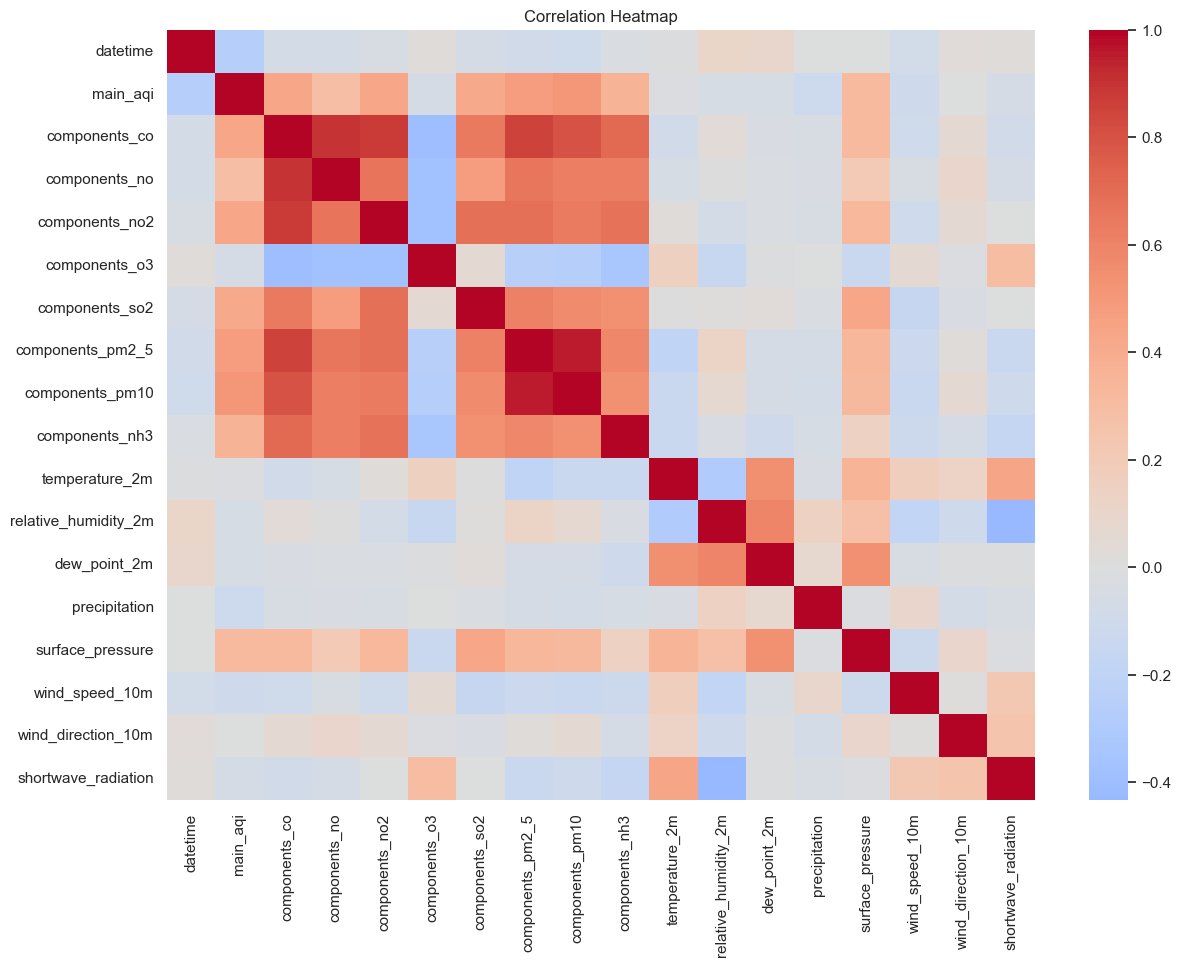

In [7]:
# -------------------------------
# 2. Correlation Matrix
# -------------------------------
corr = df.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

In [8]:
# -----------------------------------
# 3. Correlation with main_aqi only
# -----------------------------------
target_corr = corr['main_aqi'].sort_values(ascending=False)
target_corr

main_aqi                1.000000
components_pm10         0.509773
components_pm2_5        0.479081
components_co           0.433593
components_no2          0.431301
components_so2          0.423376
components_nh3          0.367252
surface_pressure        0.318207
components_no           0.290373
wind_direction_10m      0.003508
temperature_2m         -0.021394
dew_point_2m           -0.047868
relative_humidity_2m   -0.051546
components_o3          -0.059834
shortwave_radiation    -0.061162
wind_speed_10m         -0.105040
precipitation          -0.110178
datetime               -0.263992
Name: main_aqi, dtype: float64

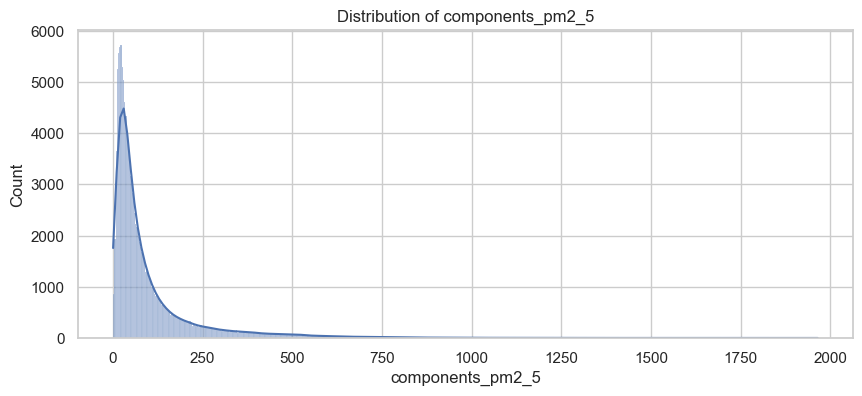

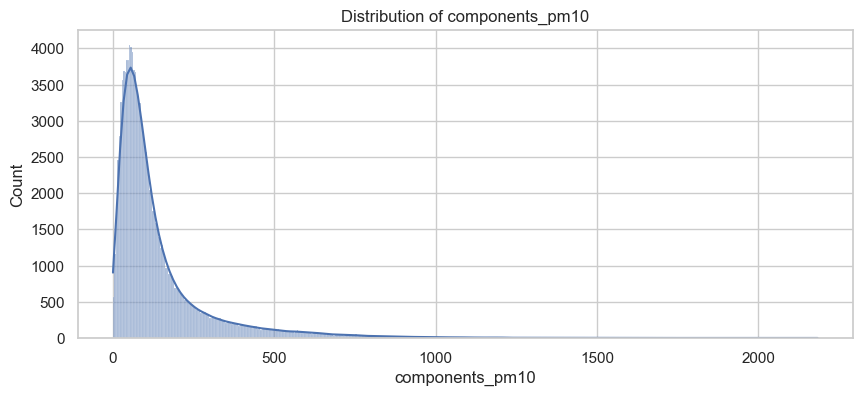

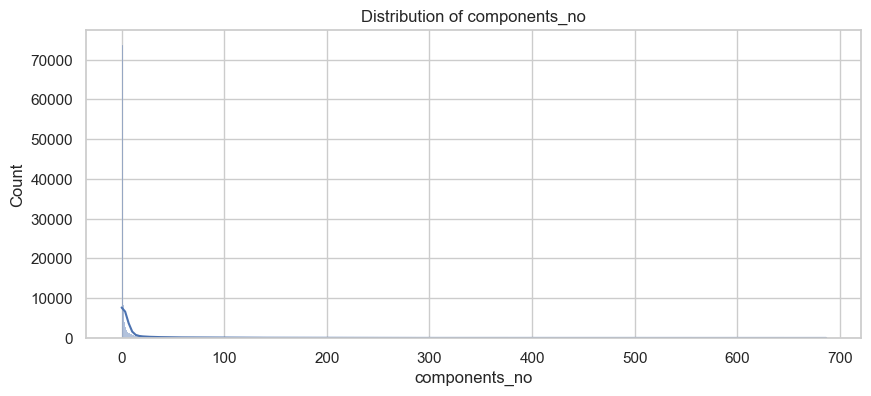

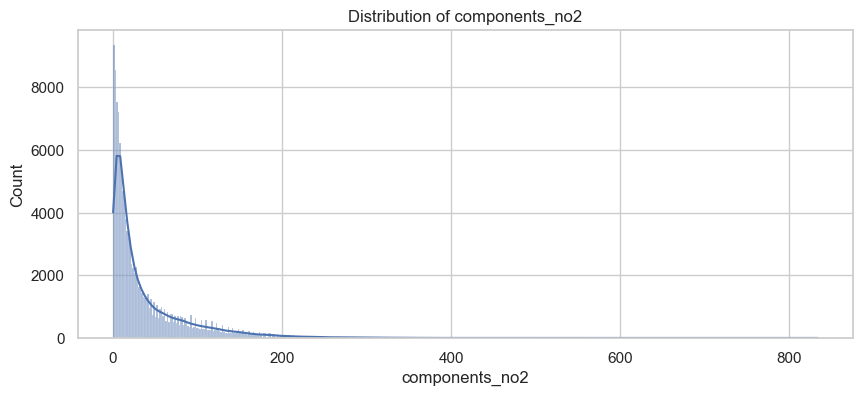

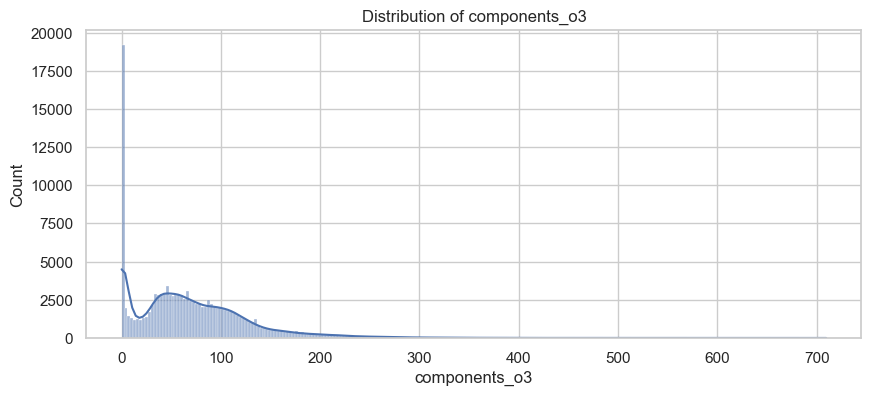

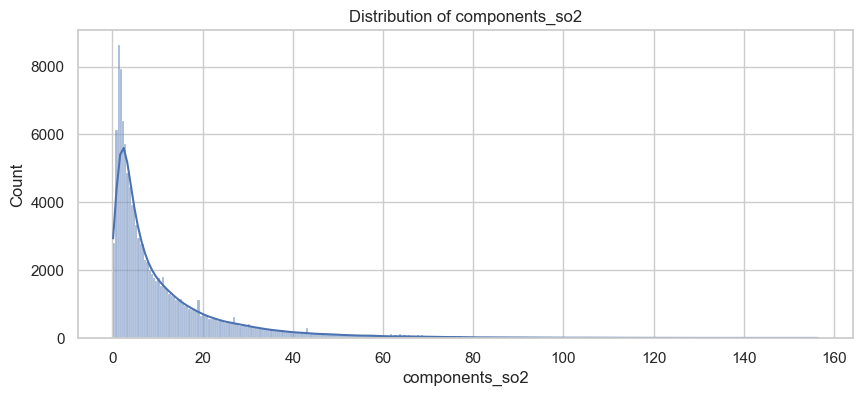

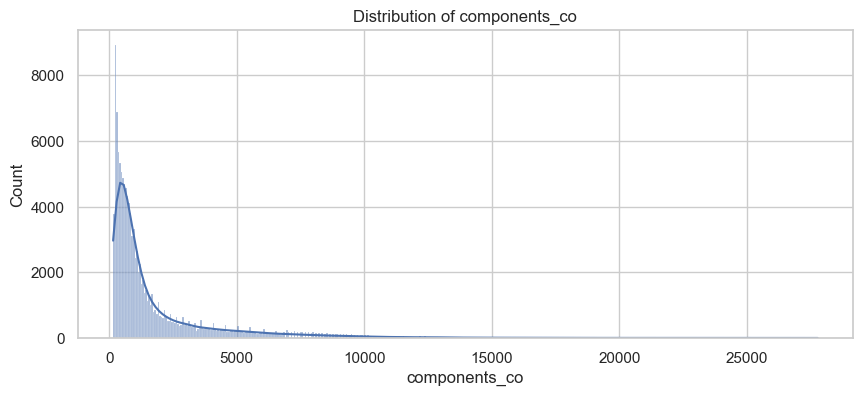

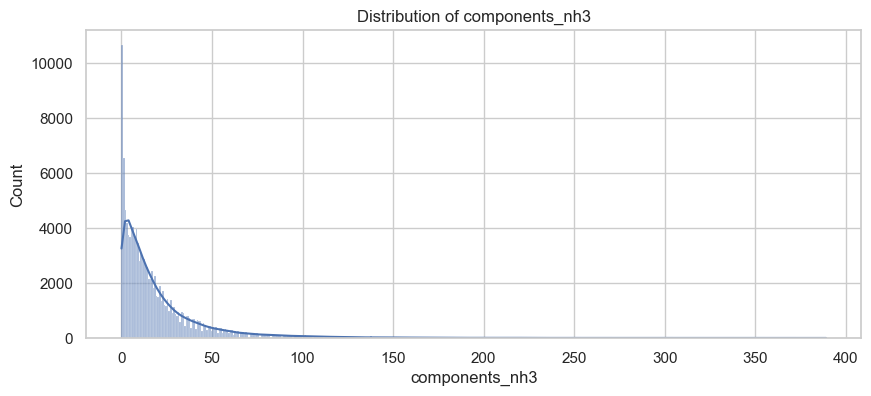

In [9]:
# -----------------------------------
# 4. Distribution Plots (Pollutants)
# -----------------------------------
pollutants = [
    'components_pm2_5','components_pm10','components_no','components_no2',
    'components_o3','components_so2','components_co','components_nh3'
]

for col in pollutants:
    plt.figure(figsize=(10, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

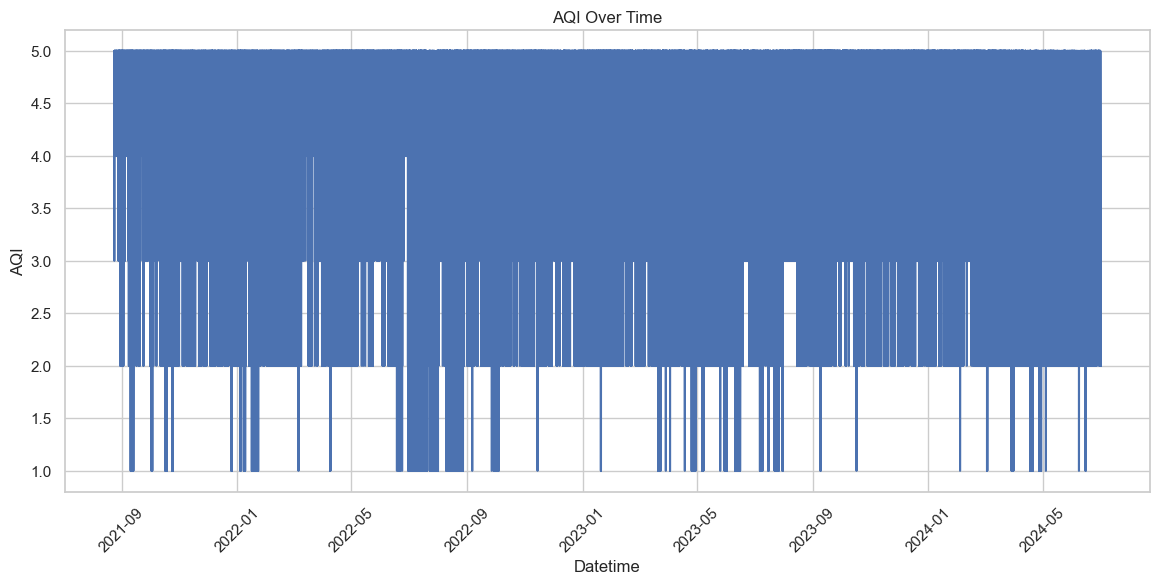

In [10]:
# -----------------------------------
# 5. Time-Series Preview
# -----------------------------------
df_sorted = df.sort_values('datetime')
plt.figure(figsize=(14,6))
plt.plot(df_sorted['datetime'], df_sorted['main_aqi'])
plt.title("AQI Over Time")
plt.xlabel("Datetime")
plt.ylabel("AQI")
plt.xticks(rotation=45)
plt.show()

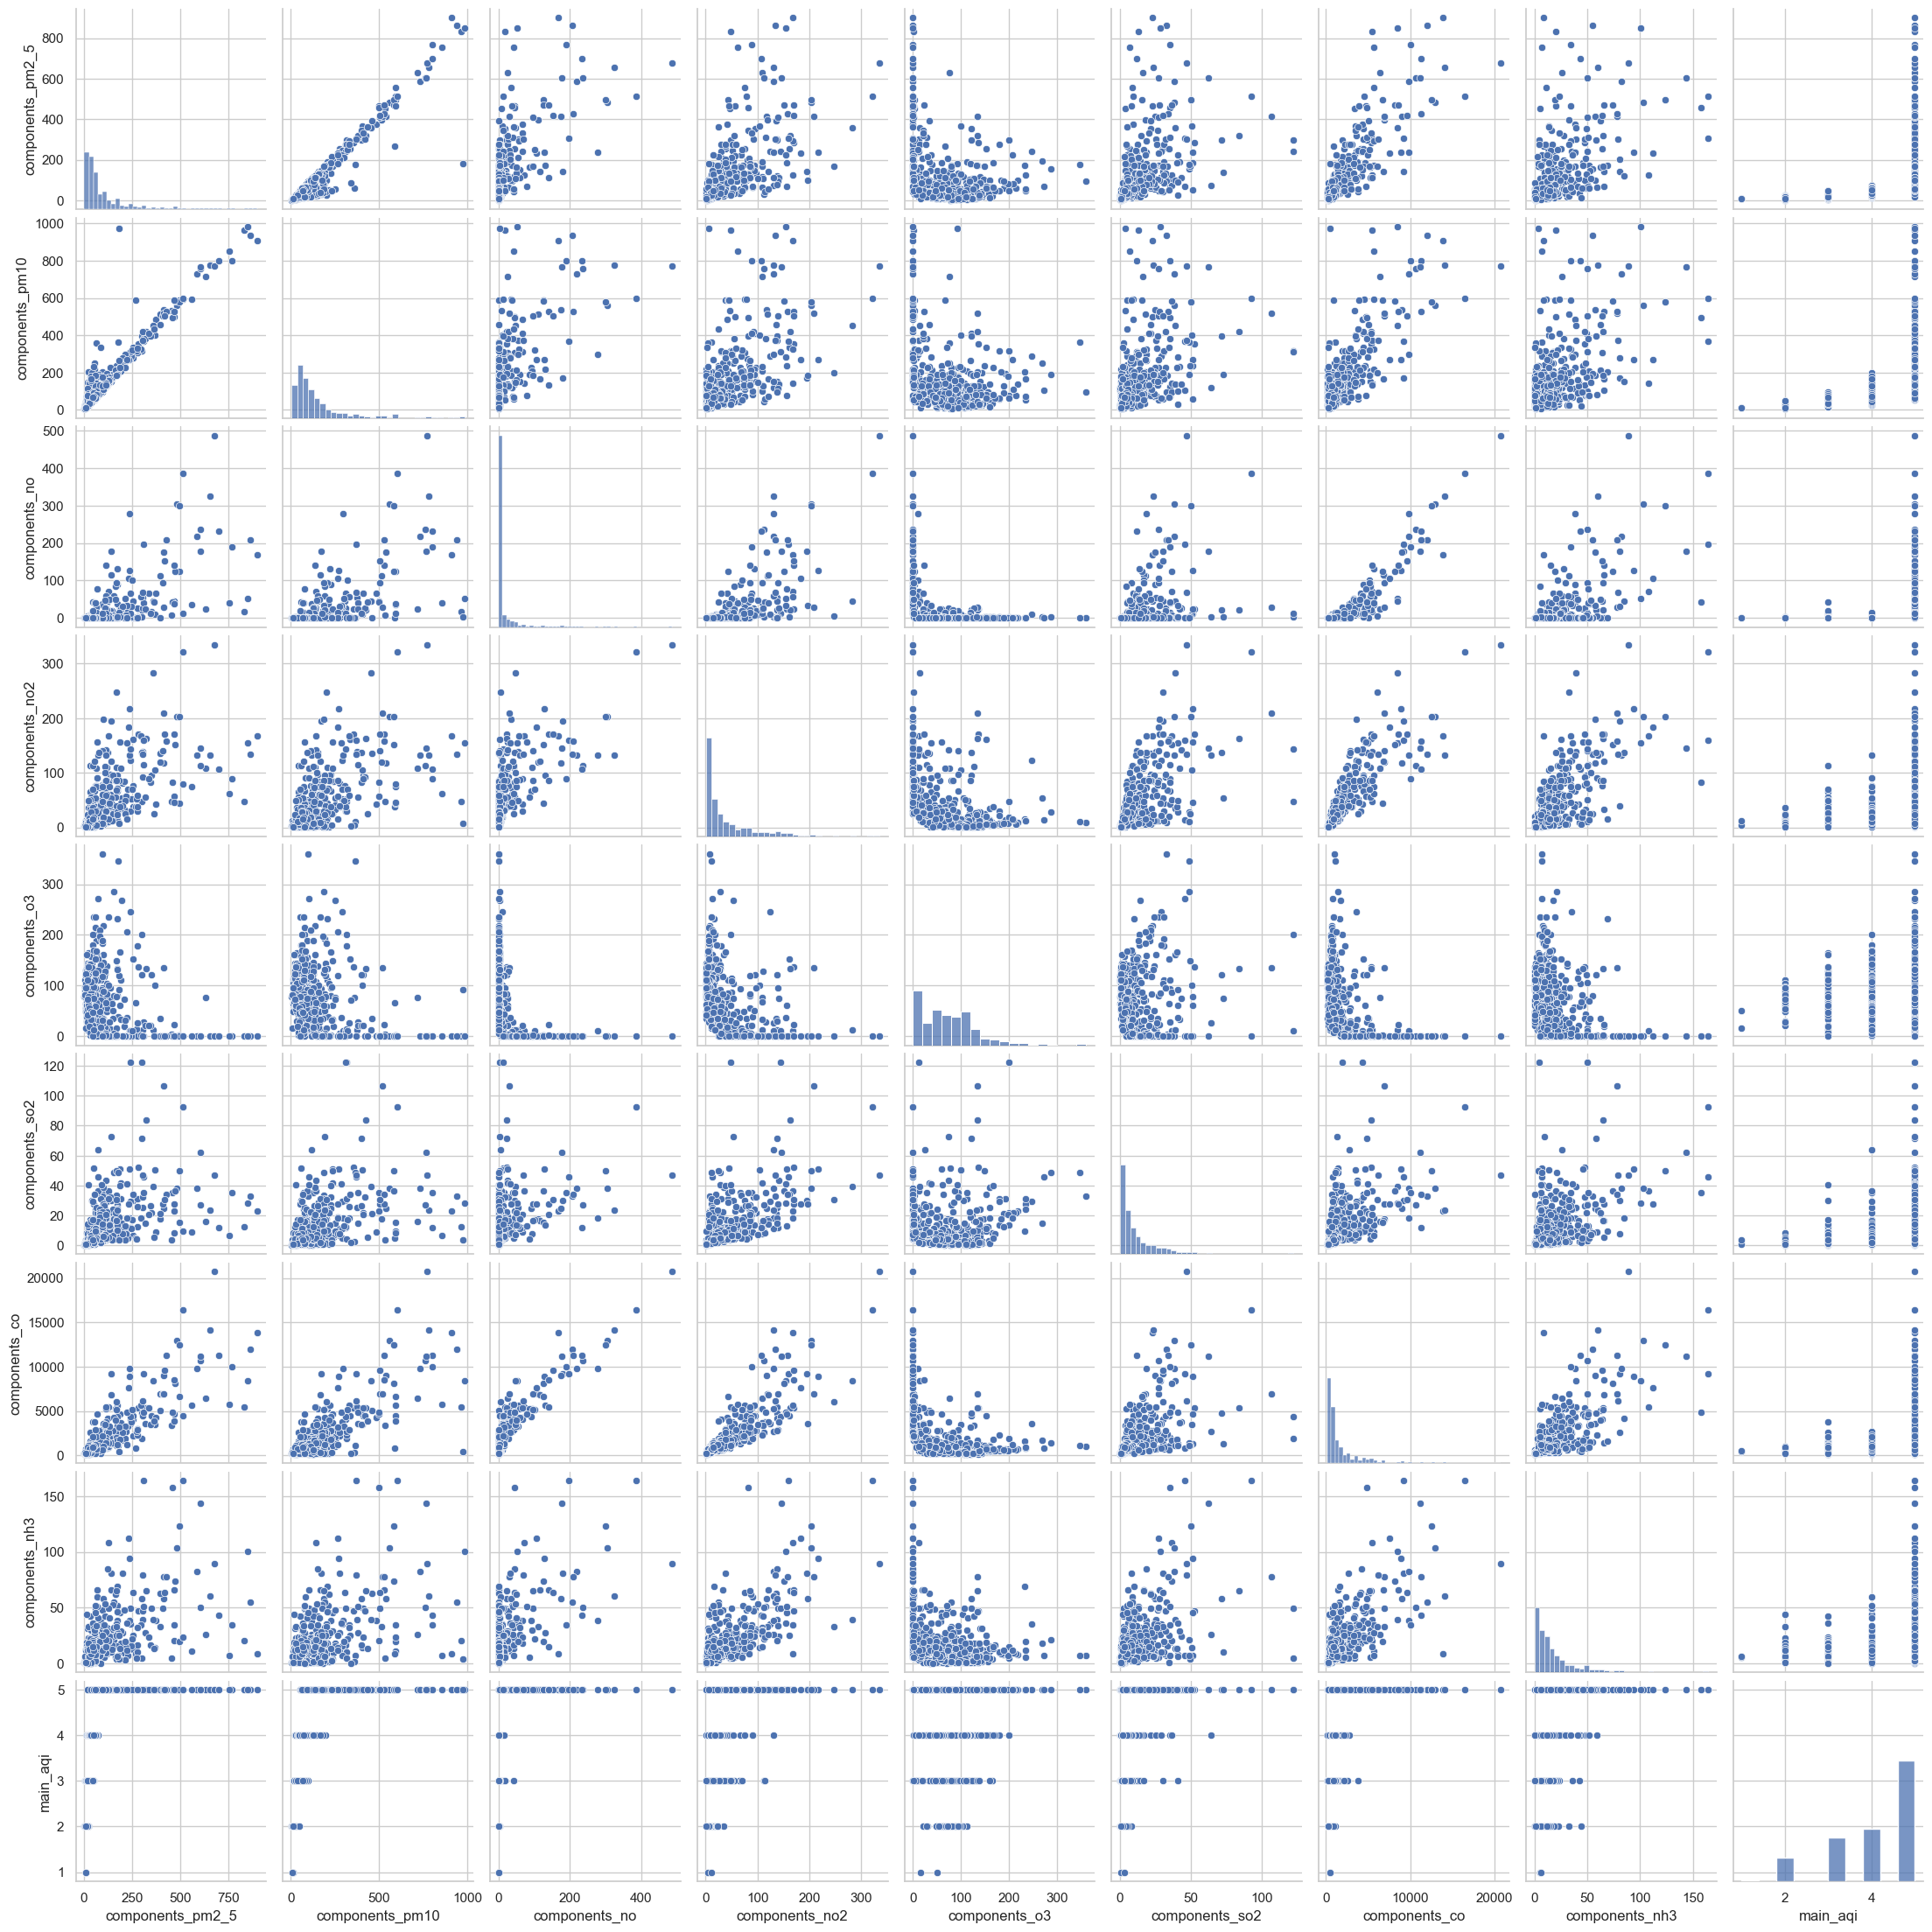

In [11]:
# -----------------------------------
# 6. Pairplot
# -----------------------------------
sns.pairplot(df[pollutants + ['main_aqi']].sample(500))  # sample for speed
plt.show()

In [12]:
# -------------------------------
# Step 7: Feature Engineering
# -------------------------------

# Ensure datetime is parsed
df['datetime'] = pd.to_datetime(df['datetime'])

# 1. Extract Time Features
df['hour'] = df['datetime'].dt.hour
df['day'] = df['datetime'].dt.day
df['weekday'] = df['datetime'].dt.weekday
df['month'] = df['datetime'].dt.month

# Season mapping function
def get_season(month):
    if month in [12, 1, 2]:
        return 0   # Winter
    elif month in [3, 4, 5]:
        return 1   # Spring
    elif month in [6, 7, 8]:
        return 2   # Summer
    else:
        return 3   # Fall

df['season'] = df['month'].apply(get_season)

# Weekend flag (Saturday=5, Sunday=6)
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)

# --------------------------------
# 2. Lag Features (1-hour before)
# --------------------------------
lag_cols = [
    'components_pm2_5','components_pm10','components_no','components_no2',
    'components_o3','components_so2','components_co','components_nh3','main_aqi'
]

for col in lag_cols:
    df[f'{col}_lag1'] = df[col].shift(1)

# --------------------------------
# 3. Rolling Averages (3h and 6h)
# --------------------------------
for col in lag_cols:
    df[f'{col}_roll3'] = df[col].rolling(window=3).mean()
    df[f'{col}_roll6'] = df[col].rolling(window=6).mean()

# Drop rows with NaN after lag/rolling
df = df.dropna().reset_index(drop=True)

df.head()

,datetime,main_aqi,components_co,components_no,components_no2,components_o3,components_so2,components_pm2_5,components_pm10,components_nh3,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,surface_pressure,wind_speed_10m,wind_direction_10m,shortwave_radiation,hour,day,weekday,month,season,is_weekend,components_pm2_5_lag1,...,components_no_lag1,components_no2_lag1,components_o3_lag1,components_so2_lag1,components_co_lag1,components_nh3_lag1,main_aqi_lag1,components_pm2_5_roll3,components_pm2_5_roll6,components_pm10_roll3,components_pm10_roll6,components_no_roll3,components_no_roll6,components_no2_roll3,components_no2_roll6,components_o3_roll3,components_o3_roll6,components_so2_roll3,components_so2_roll6,components_co_roll3,components_co_roll6,components_nh3_roll3,components_nh3_roll6,main_aqi_roll3,main_aqi_roll6
0,2021-08-24 01:00:00,5,1134.87,0.00,24.33,46.49,6.20,64.50,82.37,14.57,29.400000,56.00000,19.700000,0.0,943.20000,10.800000,92.00000,0,1,24,1,8,2,0,31.87,...,0.00,21.25,78.68,5.25,567.44,19.76,5.0,52.940000,49.538333,94.886667,81.280000,0.000000,0.000000,17.480000,16.401667,62.226667,49.828333,4.333333,4.456667,850.043333,838.360000,18.030000,12.495000,5.000000,4.666667
1,2021-08-24 01:00:00,5,834.47,0.00,7.37,60.08,1.88,62.43,78.15,23.56,21.706999,85.70637,19.206999,0.0,874.70166,3.671294,78.69010,4,1,24,1,8,2,0,64.50,...,0.00,24.33,46.49,6.20,1134.87,14.57,5.0,52.933333,50.011667,95.116667,83.170000,0.000000,0.000000,17.650000,14.773333,61.750000,53.881667,4.443333,3.696667,845.593333,808.320000,19.296667,15.430000,5.000000,4.666667
2,2021-08-24 01:00:00,4,236.99,0.00,1.24,36.12,1.37,12.08,52.14,0.25,27.400000,78.00000,23.200000,0.0,1004.10000,7.210000,268.00000,0,1,24,1,8,2,0,62.43,...,0.00,7.37,60.08,1.88,834.47,23.56,5.0,46.336667,50.048333,70.886667,83.670000,0.000000,0.000000,10.980000,14.801667,47.563333,53.881667,3.150000,3.711667,735.443333,808.320000,12.793333,15.431667,4.666667,4.833333
3,2021-08-24 01:00:00,5,1054.76,0.01,19.36,32.19,6.68,66.96,74.88,6.08,27.800000,83.00000,24.700000,0.0,976.40000,6.500000,180.00000,0,1,24,1,8,2,0,12.08,...,0.00,1.24,36.12,1.37,236.99,0.25,4.0,47.156667,50.048333,68.390000,81.638333,0.003333,0.001667,9.323333,13.401667,42.796667,52.511667,3.310000,3.821667,708.740000,779.391667,9.963333,13.996667,4.666667,4.833333
4,2021-08-24 01:00:00,5,560.76,0.00,22.28,82.25,5.72,33.24,142.92,21.28,20.614500,15.48807,-6.535500,0.0,834.57990,5.483357,156.80138,0,1,24,1,8,2,0,66.96,...,0.01,19.36,32.19,6.68,1054.76,6.08,5.0,37.426667,45.180000,89.980000,92.548333,0.003333,0.001667,14.293333,15.971667,50.186667,55.968333,4.590000,4.516667,617.503333,731.548333,9.203333,14.250000,4.666667,4.833333


In [19]:
df.columns

Index(['main_aqi', 'components_co', 'components_no', 'components_no2', 'components_o3', 'components_so2',
       'components_pm2_5', 'components_pm10', 'components_nh3', 'temperature_2m', 'relative_humidity_2m',
       'dew_point_2m', 'precipitation', 'surface_pressure', 'wind_speed_10m', 'wind_direction_10m',
       'shortwave_radiation', 'hour', 'day', 'weekday', 'month', 'season', 'is_weekend', 'components_pm2_5_lag1',
       'components_pm10_lag1', 'components_no_lag1', 'components_no2_lag1', 'components_o3_lag1',
       'components_so2_lag1', 'components_co_lag1', 'components_nh3_lag1', 'main_aqi_lag1', 'components_pm2_5_roll3',
       'components_pm2_5_roll6', 'components_pm10_roll3', 'components_pm10_roll6', 'components_no_roll3',
       'components_no_roll6', 'components_no2_roll3', 'components_no2_roll6', 'components_o3_roll3',
       'components_o3_roll6', 'components_so2_roll3', 'components_so2_roll6', 'components_co_roll3',
       'components_co_roll6', 'components_nh3_roll

In [ ]:
# 1. Prepare feature matrix and target
X = df.drop(columns=["main_aqi"])  # All columns except target
y = df["main_aqi"]                 # Target column

# 2. Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Scaling numeric features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)